In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

# Hjælpefunktioner

In [13]:
def error_on_the_mean(data, n):
    """
    Returnerer gennemsnit og usikkerhed på gennemsnittet for et datasæt.
    """
    return (np.mean(data), np.std(data) / np.sqrt(n))

In [14]:
def voltage_to_current(V, R_LB, R_HH):
    """
    Returnerer strømmen I givet spænding V og modstande R_LB og R_HH jvf. PreLab 1.
    """
    return V / (R_LB + R_HH)

In [15]:
def current_error(V, R_LB, R_HH, sigma_V, sigma_R_HH):
    """
    Returnerer usikkerhed på strømmen jvf. ophobningsloven.
    """
    return np.sqrt( (sigma_V**2)/(R_LB + R_HH)**2 + (V * sigma_R_HH)**2/(R_LB + R_HH)**4 )

In [16]:
def current_to_magnetic_field(I, mu_0, n, d):
    """
    Returnerer stykren af det magnetiske felt i HH-spolen
    """
    return (n * mu_0 * I)* (16*np.sqrt(5))/(25 * d)


In [17]:
def magnetic_field_error(I, mu_0, n, d, sigma_I, sigma_d, sigma_n):
    """
    Returnerer usikkerhed på styrken af det magnetiske felt i HH-spolen (fundet med ophobningsloven)
    """
    return (16*np.sqrt(5))/(25)*np.sqrt((n**2 * mu_0**2 * I**2 * sigma_I**2)/(d**2) + (mu_0**2 * I**2 * sigma_n**2)/(d**2) + (n**2 * mu_0**2 * I**2 * sigma_d**2)/(d**4))


In [18]:

def lin_func(x, a, b):
    "Lineær funktion til curve_fit"
    return a * x + b

In [19]:
def chi_squared(x, y, yerr, func, params):
    """
    Returnerer chi^2-værdien for et datasæt og en funktion.
    """
    return np.sum(((y - func(x, params[0], params[1])) / yerr)**2)

In [20]:
def reduced_chi_squared(x, y, yerr, func, params, n):
    """
    Returnerer den reducerede chi^2-værdi for et datasæt og en funktion.

    n er antallet af frie parametre i funktionen.
    """
    
    return chi_squared(x, y, yerr, func, params) / (len(x) - n)

In [21]:
def analyze_csv(file_location, height=0.1, prominence=0.4, distance=200):
    """
    Analyserer en CSV-fil og finder peaks i kanal B data.

    Input:
        file_location (str): Filstien til CSV-filen.
        height (float): Minimumshøjde af peaks (svarer til hvor langt under 0 V peaksne mindst skal være).
        prominence (float): Styrer hvor 'fremtrædende' peaks skal være for at blive detekteret.
        distance (int): Minimum afstand (i indeks!). Dvs. antal målinger mellem peaks.

    Output:
        dict: Et dictionary der indeholder arrays med rådata, placeringen af peaksne og værdien af kanal A ved peaksne (time_arr, voltage_arr_A, voltage_arr_B, peaks, voltage_A_at_peaks).
    """
    # Load data from CSV file
    data = pd.read_csv(file_location, header=[0, 1])
    time_arr = data.iloc[:, 0].to_numpy()
    voltage_arr_A = data.iloc[:, 1].to_numpy()
    voltage_arr_B = data.iloc[:, 2].to_numpy()

    # Find peaks i kanal B data
    peaks, _ = find_peaks(-voltage_arr_B, height=height, prominence=prominence, distance=distance)

    # Debug: Print antal peaks fundet
    #print(f"Fandt {len(peaks)} peaks i '{file_location}'")

    # # Plot data med peaks
    # plt.figure(figsize=(10, 5))
    # plt.plot(time_arr, voltage_arr_A, label='Voltage A')
    # plt.plot(time_arr, voltage_arr_B, label='Voltage B')
    # plt.plot(time_arr[peaks], voltage_arr_B[peaks], "x", label='Peaks', color='red', markersize=8)
    # plt.xlabel('Time (ms)')
    # plt.ylabel('Voltage (V)')
    # plt.title('Voltage vs Time')
    # plt.legend()
    # plt.grid()
    # plt.show()

    # Returner data og peaks, samt kanal A værdier ved peaks
    return {
        "time": time_arr,
        "voltage_A": voltage_arr_A,
        "voltage_B": voltage_arr_B,
        "peaks": peaks,
        "voltage_A_at_peaks": voltage_arr_A[peaks]
    }

# Eksempel
file_location = "CSV_data/15.7 MHz.csv"
result = analyze_csv(file_location)

# Fitning af data med forskellige værdier af R_LB

--- Analyserer data for R_LB = 0 Ohm ---
Fittets parametre for RL_B = 0 a = 2.02e-11 ± 1e-12, b = -9.4e-05 ± 1e-04
Gamma for R_LB = 0 er 4.96e+10 ± 2e+09 (rad/s T)
Gamma for R_LB = 0 er 7.89e+09 ± 6e+07 (Hz/T)
Reduceret chi^2-værdi for 0 er 0.05


--- Analyserer data for R_LB = 2.5 Ohm ---
Fittets parametre for RL_B = 2.5 a = 8.97e-12 ± 4e-13, b = -4.3e-05 ± 5e-05
Gamma for R_LB = 2.5 er 1.11e+11 ± 5e+09 (rad/s T)
Gamma for R_LB = 2.5 er 1.77e+10 ± 1e+08 (Hz/T)
Reduceret chi^2-værdi for 2.5 er 0.06


--- Analyserer data for R_LB = 5 Ohm ---
Fittets parametre for RL_B = 5 a = 5.77e-12 ± 2e-13, b = -2.7e-05 ± 3e-05
Gamma for R_LB = 5 er 1.73e+11 ± 7e+09 (rad/s T)
Gamma for R_LB = 5 er 2.76e+10 ± 2e+08 (Hz/T)
Reduceret chi^2-værdi for 5 er 0.06




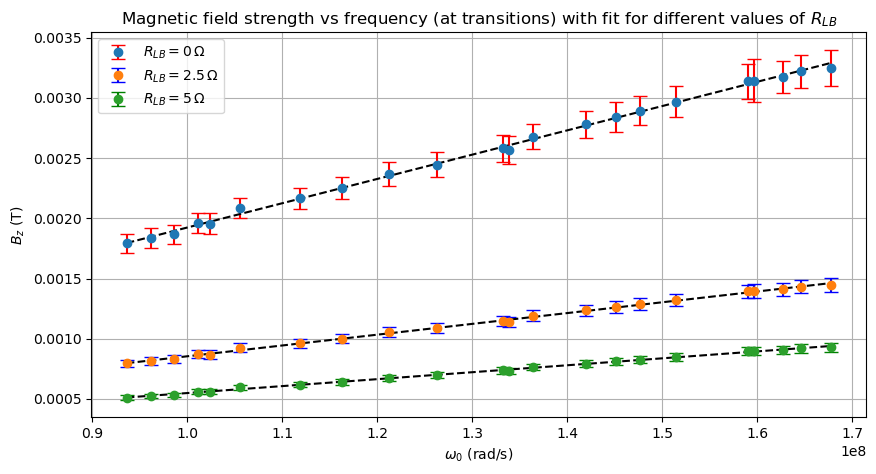

In [22]:
# Vacuum permeabiliteten
mu_0 = 1.2566 * 10 **(-6) # N/A^2

# Indeholder alle frekvenserne vi har målt ved i MHz
frequency_list = [14.9, 15.3, 15.7, 16.1, 16.3, 16.8, 17.8, 18.5, 19.3, 20.1, 21.2, 21.3, 21.7, 22.6, 23.1, 23.5, 24.1, 25.3, 25.4, 25.9, 26.2, 26.7]

frequency_list_HZ = np.array(frequency_list) * 10**6 *2*np.pi # Konverter frekvenser i MHz til vinkelfrekvenser i rad/s

# En liste med alle filnavne i formatet xx MHz.csv
file_list = [f"CSV_data/{str(freq)} MHz.csv" for freq in frequency_list]

def main(file_list, R_LB=5, R_HH=2, sigma_R_HH=0.001, n=122, sigma_n=2, d=0.3, sigma_d=0.01):
    """
    Hovedfunktion til at analysere data fra CSV-filerne. Laver et fit for en given værdi af R_LB (spøgelsesmodstanden/"ghost resistance") og returnerer parametrene for det lineære fit, samt værdierne for magnetfeltsstyrken som funktion af frekvensen og dens usikkerhed.

    R_LB er modstanden i Leybold supply-boksen. Enten 0, 2.5 eller 5 ohm.
    """
    print(f"--- Analyserer data for R_LB = {R_LB} Ohm ---")

    voltage_A_averages = []
    voltage_A_errors = []

    for file_location in file_list:
        # Analyser CSV-filen og gem resultaterne
        result = analyze_csv(file_location)
        
        # Beregn gennemsnit og usikkerhed for kanal A ved peaks
        voltage_A_mean, voltage_A_error = error_on_the_mean(result["voltage_A_at_peaks"], len(result["peaks"]))
        
        # Gem resultaterne
        voltage_A_averages.append(voltage_A_mean)
        voltage_A_errors.append(voltage_A_error)

    # Konverter til numpy arrays for nemmere håndtering
    voltage_A_averages = np.array(voltage_A_averages)
    voltage_A_errors = np.array(voltage_A_errors)

    # Omregning til strøm
    current_A_averages = []
    current_A_errors = []

    for i in range(len(voltage_A_averages)):
        V = voltage_A_averages[i]
        sigma_V = voltage_A_errors[i]
        I = voltage_to_current(V, R_LB=R_LB, R_HH=R_HH)
        I_error = current_error(V, R_LB=R_LB, R_HH=R_HH, sigma_V=sigma_V, sigma_R_HH=sigma_R_HH)
        current_A_averages.append(I)
        current_A_errors.append(I_error)

    # Konverter til numpy arrays for nemmere håndtering
    current_A_averages = np.array(current_A_averages)
    current_A_errors = np.array(current_A_errors)

    # Omregning til magnetfeltsstyrke af magnetfeltet fra HH-spolen
    HH_B_averages = []
    HH_B_errors = []

    for i in range(len(current_A_averages)):
        I = current_A_averages[i]
        sigma_I = current_A_errors[i]
        B = current_to_magnetic_field(I=I, mu_0=mu_0, n=n, d=d)
        B_error = magnetic_field_error(I=I, mu_0=mu_0, n=n, d=d, sigma_I=sigma_I, sigma_d=sigma_d, sigma_n=sigma_n)
        HH_B_averages.append(B)
        HH_B_errors.append(B_error)

    # Konverter til numpy arrays for nemmere håndtering
    HH_B_averages = np.array(HH_B_averages)
    HH_B_errors = np.array(HH_B_errors)

    # Fitning af data
    popt, pcov = curve_fit(lin_func, frequency_list_HZ, HH_B_averages, sigma=HH_B_errors, absolute_sigma=True)
    a_fit, b_fit = popt

    # Find usikkerhed på fitparametre
    perr = np.sqrt(np.diag(pcov))
    print(f"Fittets parametre for RL_B = {R_LB} a = {a_fit:.2e} ± {perr[0]:.0e}, b = {b_fit:.1e} ± {perr[1]:.0e}")

    gamma = 1/a_fit
    gamma_error = np.sqrt(perr[0]**2 / a_fit**4)

    print(f"Gamma for R_LB = {R_LB} er {gamma:.2e} ± {gamma_error:.0e} (rad/s T)")

    # omega = 2 * pi * f så f = omega / (2 * pi)
    # Omregn vinkelfrekvens til frekvens
    gamma_Hz = gamma / (2 * np.pi)
    gamma_Hz_error = gamma_error / (2 * np.pi)**2
    print(f"Gamma for R_LB = {R_LB} er {gamma_Hz:.2e} ± {gamma_Hz_error:.0e} (Hz/T)")

    # Find chi^2-værdi
    chi2_value = chi_squared(frequency_list_HZ, HH_B_averages, HH_B_errors, lin_func, params=popt)

    # Find reduceret chi^2-værdi
    reduced_chi2_value = reduced_chi_squared(frequency_list_HZ, HH_B_averages, HH_B_errors, lin_func, params=popt, n=len(popt))
    print(f"Reduceret chi^2-værdi for {R_LB} er {reduced_chi2_value:.2f}")
    print("\n")

    return {
        "gamma": gamma,
        "gamma_error": gamma_error,
        "gamma_Hz": gamma_Hz,
        "gamma_Hz_error": gamma_Hz_error,
        "chi2": chi2_value,
        "reduced_chi2": reduced_chi2_value,
        "a_fit": a_fit,
        "b_fit": b_fit,
        "popt": popt,
        "pcov": pcov,
        "frequency_list": frequency_list,
        "HH_B_averages": HH_B_averages,
        "HH_B_errors": HH_B_errors
    }
    

# Værdier for forskellige værdier af R_LB
res_0 = main(file_list, R_LB=0, R_HH=2, sigma_R_HH=0.001, n=124, sigma_n=2, d=0.3, sigma_d=0.01)
res_2_5 = main(file_list, R_LB=2.5, R_HH=2, sigma_R_HH=0.001, n=124, sigma_n=2, d=0.3, sigma_d=0.01)
res_5 = main(file_list, R_LB=5, R_HH=2, sigma_R_HH=0.001, n=124, sigma_n=2, d=0.3, sigma_d=0.01)

# Plotting af resultaterne for forskellige værdier af R_LB
plt.figure(figsize=(10, 5))
plt.errorbar(frequency_list_HZ, res_0["HH_B_averages"], yerr=res_0["HH_B_errors"], fmt='o', label=r'$R_{LB} = 0 \, \Omega$', capsize=5, ecolor='red')
plt.errorbar(frequency_list_HZ, res_2_5["HH_B_averages"], yerr=res_2_5["HH_B_errors"], fmt='o', label=r'$R_{LB} = 2.5 \, \Omega$', capsize=5, ecolor='blue')
plt.errorbar(frequency_list_HZ, res_5["HH_B_averages"], yerr=res_5["HH_B_errors"], fmt='o', label=r'$R_{LB} = 5 \, \Omega$', capsize=5, ecolor='green')
plt.plot(frequency_list_HZ, lin_func(np.array(frequency_list_HZ), *res_0["popt"]), color="black", linestyle="dashed")
plt.plot(frequency_list_HZ, lin_func(np.array(frequency_list_HZ), *res_2_5["popt"]), color="black", linestyle="dashed")
plt.plot(frequency_list_HZ, lin_func(np.array(frequency_list_HZ), *res_5["popt"]), color="black", linestyle="dashed")
plt.xlabel(r'$\omega_0$ (rad/s)')
plt.ylabel(r'$B_z$ (T)')
plt.title(r'Magnetic field strength vs frequency (at transitions) with fit for different values of $R_{LB}$')
plt.grid()
plt.legend()
plt.show()
    
